In [24]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame

from sklearn import cluster

from sklearn import preprocessing

import alphashape
from shapely.geometry import Polygon, Point, LineString

from sklearn import preprocessing

from descartes import PolygonPatch
import alphashape
import shapely

from sklearn.mixture import GaussianMixture
import matplotlib.patches as patches

import scipy.optimize as so
import os

import time

from sklearn.decomposition import PCA

(500, 2)
(500, 2)
(500, 2)
(500, 2)


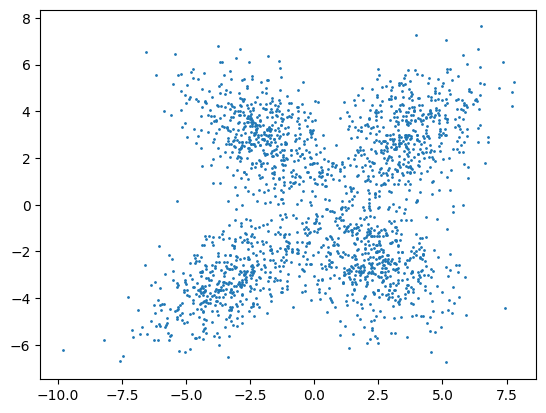

In [5]:
rng = np.random.default_rng(1234)
mean_list = [np.array([-3,-3]), np.array([-2,3]), np.array([3.5,3]), np.array([2.5,-2.5]), np.array([-1,1])]
#var_list = [np.array([[1,2],[2,1]]), np.array([[1.5,-2],[-2,1]]), np.array([[1,2], [2,2]]), np.array([[1, -3], [-3, 1]]), np.array([[1,3], [3,1]])]
var_list = [np.array([[3,1.5],[1.5,2]]), np.array([[2,-1],[-1,2]]), np.array([[2,0.8], [0.8,2]]), np.array([[2, -0.5], [-0.5, 2]]), np.array([[3,1], [1,3]])]

data_gaussian = np.array([[0,0]])
for i in range(4):
    _data = rng.multivariate_normal(mean_list[i], var_list[i], size = 500)
    print(_data.shape)
    data_gaussian = np.concatenate((data_gaussian, _data), axis = 0)

data_gaussian = data_gaussian[1:,:]


#plt.scatter(X_scaled[:,0], X_scaled[:,1])
plt.scatter(data_gaussian[:,0], data_gaussian[:,1], s = 1)

(500, 2)
(500, 2)


(-5.0, 10.0)

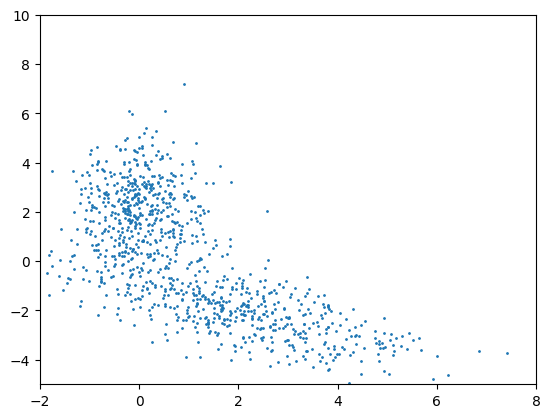

In [25]:
rng = np.random.default_rng(1234)
mean_list = [np.array([0,2]), np.array([2,-2])]
var_list = [np.array([[0.4, 0], [0,2]]), np.array([[3,-1.5],[-1.5,1.5]])]
#var_list = [np.array([[3,1.5],[1.5,2]]), np.array([[2,-1],[-1,2]]), np.array([[2,0.8], [0.8,2]]), np.array([[2, -0.5], [-0.5, 2]]), np.array([[3,1], [1,3]])]

data_gaussian = np.array([[0,0]])
for i in range(2):
    _data = rng.multivariate_normal(mean_list[i], var_list[i], size = 200)
    print(_data.shape)
    data_gaussian = np.concatenate((data_gaussian, _data), axis = 0)

data_gaussian = data_gaussian[1:,:]


#plt.scatter(X_scaled[:,0], X_scaled[:,1])
plt.scatter(data_gaussian[:,0], data_gaussian[:,1], s = 1)
plt.xlim([-2,8])
plt.ylim([-5,10])


In [61]:
X_train = data_gaussian

scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)

In [62]:
def uncertain_set_construct(X, eps = 3, min_samples = 5, k_cluster = 5, plot_fig = False):
    db = cluster.DBSCAN(eps = eps, min_samples = min_samples).fit(X)
    X_clean = X[db.labels_ != -1,:]
    
    outliers = X[db.labels_ == -1,:]
    
    gmm = GaussianMixture(n_components = k_cluster, covariance_type = "full", n_init = 200)
    gmm.fit(X_clean)

    if plot_fig:
        plt.figure(figsize = (6,6))
        plt.scatter(X[db.labels_ == -1, 0], X[db.labels_ == -1, 1], 1,c = "k")
        
        plt.scatter(X_clean[:,0],X_clean[:,1], 0.1, c = gmm.fit_predict(X_clean), cmap = plt.cm.winter)
        ax = plt.gca()
        # ax.set(aspect = "equal",xlim = [-8,8],ylim = [-11,10])
    print("outliers is {0:02f}% percent".format((1 - len(X_clean)/len(X))*100))
    
    return gmm, X_clean, outliers

In [85]:
from sklearn.decomposition import PCA
# temp_solar_3 = np.concatenate((temp_diff2.reshape(-1,1),solar_diff2.reshape(-1,1)), axis = 1)
# X_train = np.nan_to_num(temp_solar_3, nan = 0.0)

################ preprocessing the data ##################
scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)
    
X_list = []
n_clusters = 2

start_dbs = time.time()
eps = 0.14  ## 0.12
gmm, X_clean, outliers = uncertain_set_construct(X_scaled, eps =eps, min_samples = 3, k_cluster = n_clusters)
cls_labels = gmm.predict(X_clean)


outliers is 6.100000% percent


In [86]:
def comput_sqrtM(C_mat):
    v, P = np.linalg.eig(C_mat)
    Q = P@np.diag(v**(-0.5))@np.linalg.inv(P)
    return Q


def check_coverage(points, shp):
    inside_num = 0
    for _, point in enumerate(points):
        point_to_check = Point(*point)
        inside_num += shp.contains(point_to_check)
        #inside_num +=  point_to_check.within(shp)
    print("percentage of coverage is: ", inside_num/(len(points)))

outliers is 6.100000% percent
the area of the uncertainty set is:  10.578111997963457
computation time of DBP is 1.502408504486084
percentage of coverage is:  0.971


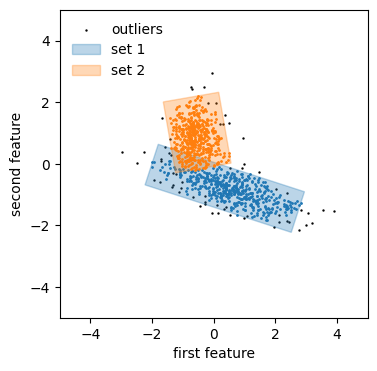

In [87]:
###########  box plot ###########


################ preprocessing the data ##################
scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)
    
X_list = []
n_clusters = 2

start_dbs = time.time()

min_samples = 3
gmm, X_clean, outliers = uncertain_set_construct(X_scaled, eps = eps, min_samples = min_samples, k_cluster = n_clusters)
cls_labels = gmm.predict(X_clean)

for i in range(n_clusters):
    X_list.append(X_clean[ cls_labels == i,:])


fig, axs = plt.subplots(figsize=(4,4))

axs.scatter(outliers[:,0], outliers[:,1], 0.5, color = "k", label = "outliers")

area = 0
shp_list = []
for i, X in enumerate(X_list):
    
    if len(X) == 0:
        continue
        
    X_mean = np.mean(X, axis = 0)
    X_centered = X - X_mean  ### generate centered data ###
    
    pca = PCA(n_components = 2).fit(X_centered)
    
    X_pca = pca.fit_transform(X_centered)
    
    pca_min = np.min(X_pca,axis = 0).reshape(-1,1)
    pca_max = np.max(X_pca,axis = 0).reshape(-1,1)
    


    X_min = pca.components_*pca_min
    X_max = pca.components_*pca_max
    pca1_minmax = [pca_min[0], pca_max[0]]
    pca2_minmax = [pca_min[1], pca_max[1]]

    ext_points = [] ### extreme points 
    for pca_1 in pca1_minmax:
        for pca_2 in pca2_minmax:
            ext_points.append([pca_1,pca_2])
            
    points = []        
    for point in ext_points:
        points.append(X_mean.reshape(-1,1) + pca.components_.T@np.array(point))
        #points.append(pca_a+pca_b)
        
    shp = alphashape.alphashape(points, alpha = 0.)
    shp_list.append(shp)
    
#    axs.scatter(X[:,0], X[:,1],0.5, color = f"C{i+1}")

#     shp_x, shp_y = shp.exterior.xy
    
#     axs.fill(shp_x+X_mean[0], shp_y+X_mean[1], alpha = 0.3, color = f"C{i}") 
    
    area += shapely.area(shp)
    
    if isinstance(shp, Polygon):
        axs.scatter(X[:,0], X[:,1],1, color = f"C{i}")
        shp_x, shp_y = shp.exterior.xy
    
        axs.fill(shp_x, shp_y, alpha = 0.3, color = f"C{i}", label = "set {i}".format(i = i+1)) 
    if isinstance(shp, LineString):
        axs.plot(shp.coords,linewidth = 1, label = "set {i}".format(i = i+1))
   

axs.legend(loc = 2, frameon = False)

end_dbs = time.time()

fontsize = 12        
        
axs.set(
aspect="equal",
#    title="2-dimensional dataset with principal components",
xlabel="first feature",
ylabel="second feature",xlim = [-5,5],ylim = [-5,5])

union_polygon = shp_list[0]
for shape in shp_list[1:]:
    union_polygon = union_polygon.union(shape)

union_polygon.area
   
plt.savefig("db_gmm_pca_"+"{0}".format(min_samples)+".png",bbox_inches = "tight")
    
print("the area of the uncertainty set is: ", union_polygon.area)
print("computation time of DBP is", end_dbs - start_dbs)
check_coverage(X_scaled, union_polygon)

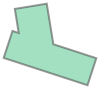

In [71]:
union_polygon

outliers is 5.400000% percent
the area of the uncertainty set is:  11.424807057941562
computation time of DBP is 8.503003597259521
percentage of coverage is:  0.977


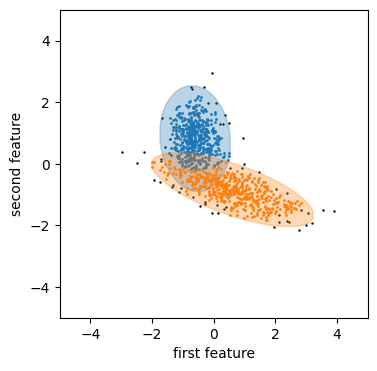

In [84]:
############### Ellipsoide plot #################

scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)
# X_scaled = X_train
    
X_list = []
n_clusters = 2

start_dbs = time.time()

min_samples = 3
gmm, X_clean, outliers = uncertain_set_construct(X_scaled, eps = eps, min_samples = min_samples, k_cluster = n_clusters)
cls_labels = gmm.predict(X_clean)

for i in range(n_clusters):
    X_list.append(X_clean[ cls_labels == i,:])


fig, axs = plt.subplots(figsize=(4,4))

axs.scatter(outliers[:,0], outliers[:,1], 0.5, color = "k",label = "outliers")

area = 0
shp_list = []
for i, X in enumerate(X_list):
    
    if len(X) == 0:
        continue
        
    X_mean = np.mean(X, axis = 0)
    X_centered = X - X_mean  ### generate centered data ###
    
    pca = PCA(n_components = 2).fit(X_centered)

    Sigma = pca.components_.T@np.diag(pca.singular_values_)@pca.components_
    Sigma_inv2 =  np.linalg.inv(Sigma)
    # Sigma_inv2 =  comput_sqrtM(Sigma) #np.linalg.inv(Sigma) # comput_sqrtM(Sigma)

    pc1_range = np.linspace(np.min(X_centered[:,0])*2,np.max(X_centered[:,0])*3,500) + X_mean[0]
    pc2_range = np.linspace(np.min(X_centered[:,1])*2,np.max(X_centered[:,1])*3,500) + X_mean[1]
    
    Points_ellip = []

    gmm_selection = True
    
    if gmm_selection == True:
        X_mean = gmm.means_[i,:]
        Sigma = gmm.covariances_[i]
        Sigma_inv2 =  comput_sqrtM(Sigma) #np.linalg.inv(Sigma)
        
    varrho = np.max(np.array([np.linalg.norm(Sigma_inv2@(X[t,:] - X_mean), 2) for t in range(X.shape[0])]))
    
    
    for k in range(len(pc1_range)):
        for j in range(len(pc2_range)):
            point = np.array([pc1_range[k], pc2_range[j]])
            if np.linalg.norm(Sigma_inv2@(point - X_mean), 2) <= varrho:
                Points_ellip.append(point)
            
    shp = alphashape.alphashape(Points_ellip, alpha = 0.)
    shp_list.append(shp)
    
    
    area += shapely.area(shp)
    
#    if isinstance(shp, Polygon):
    axs.scatter(X[:,0], X[:,1],1, color = f"C{i}")
    shp_x, shp_y = shp.exterior.xy
    
    axs.fill(shp_x, shp_y, alpha = 0.3, color = f"C{i}", label = "set {i}".format(i = i+1)) 
    
    if isinstance(shp, LineString):
        axs.plot(shp.coords,linewidth = 1, label = "set {i}".format(i = i+1))


# axs.legend(loc = 2, frameon = False)

end_dbs = time.time()

fontsize = 12        
        
axs.set(
aspect="equal",
#    title="2-dimensional dataset with principal components",
xlabel="first feature",
ylabel="second feature",xlim = [-5,5],ylim = [-5,5])
   
plt.savefig("ellip_db_gmm_pca_"+"{0}".format(min_samples)+".png",bbox_inches = "tight")

union_polygon = shp_list[0]
for shape in shp_list[1:]:
    union_polygon = union_polygon.union(shape)




print("the area of the uncertainty set is: ", union_polygon.area)
print("computation time of DBP is", end_dbs - start_dbs)
check_coverage(X_scaled, union_polygon)

In [73]:
###########
###  calculate the computation time for constructing the uncertainty set
###########
X_list = []
n_clusters = 2

start_time = time.time()

min_samples = 3
gmm, X_clean, outliers = uncertain_set_construct(X_scaled, eps = eps, min_samples = min_samples, k_cluster = n_clusters)
cls_labels = gmm.predict(X_clean)

for i in range(n_clusters):
    X_list.append(X_clean[ cls_labels == i,:])

area = 0
shp_list = []
for i, X in enumerate(X_list):
    
    if len(X) == 0:
        continue
        
    X_mean = np.mean(X, axis = 0)
    X_centered = X - X_mean  ### generate centered data ###
    
    pca = PCA(n_components = 2).fit(X_centered)

    # Sigma = pca.components_.T@np.diag(pca.singular_values_)@pca.components_
    # Sigma_inv2 =  np.linalg.inv(Sigma)
    # Sigma_inv2 =  comput_sqrtM(Sigma) #np.linalg.inv(Sigma) # comput_sqrtM(Sigma)
        
    Points_ellip = []

    gmm_selection = True
    
    if gmm_selection == True:
        X_mean = gmm.means_[i,:]
        Sigma = gmm.covariances_[i]
        Sigma_inv2 =  comput_sqrtM(Sigma) #np.linalg.inv(Sigma)
        
    varrho = np.max(np.array([np.linalg.norm(Sigma_inv2@(X[t,:] - X_mean), 2) for t in range(X.shape[0])]))
end_time = time.time()

end_time - start_time

outliers is 5.400000% percent


1.8716824054718018

In [ ]:
# pc1_range = np.linspace(-4,4,500)
# pc2_range = np.linspace(-4,4,500)
# Points_ellip = []
# data = X_list[-1]

# Sigma_inv2 = comput_sqrtM(Sigma)

# varrho = np.max(np.array([np.linalg.norm(Sigma_inv2@(data[i,:] - X_mean), 2) for i in range(data.shape[0])]))

# print(varrho)

# for i in range(len(pc1_range)):
#     for j in range(len(pc2_range)):
#         point = np.array([pc1_range[i], pc2_range[j]])
#         if np.linalg.norm(Sigma_inv2@(point - X_mean), 2) <= varrho:
#             Points_ellip.append(point)
            
# shp = alphashape.alphashape(Points_ellip, alpha = 0.)

# shp_x, shp_y = shp.exterior.xy

# fig, axs = plt.subplots()
# axs.scatter(data[:,0], data[:,1])
# axs.fill(shp_x, shp_y, alpha = 0.3, color = f"C{i}", label = "set {i}".format(i = i+1)) 

In [ ]:
# pc1_range = np.linspace(-4,4,500)
# pc2_range = np.linspace(-4,4,500)
# Points_ellip = []
# data = X_list[-1]

# Sigma_inv2 = np.linalg.inv(Sigma)

# varrho = np.max(np.array([np.linalg.norm(Sigma_inv2@(data[i,:] - X_mean), 2) for i in range(data.shape[0])]))

# print(varrho)

# for i in range(len(pc1_range)):
#     for j in range(len(pc2_range)):
#         point = np.array([pc1_range[i], pc2_range[j]])
#         if np.linalg.norm(Sigma_inv2@(point - X_mean), 2) <= varrho:
#             Points_ellip.append(point)
            
# shp = alphashape.alphashape(Points_ellip, alpha = 0.)

# shp_x, shp_y = shp.exterior.xy

# fig, axs = plt.subplots()
# axs.scatter(data[:,0], data[:,1])
# axs.fill(shp_x, shp_y, alpha = 0.3, color = f"C{i}", label = "set {i}".format(i = i+1)) 

In [74]:
Points_ellip

[]

In [75]:
union_polygon = shp_list[0]
for shape in shp_list[1:]:
    union_polygon = union_polygon.union(shape)

union_polygon.area

IndexError: list index out of range

In [ ]:
check_coverage(X_scaled, union_polygon)

In [ ]:
start_dbs - end_dbs

In [ ]:
X_mean.reshape(-1,1) + points[1]

the area of the uncertainty set is:  34.9775650746272
box uncertainty set computation time: 0.0
percentage of coverage is:  0.996


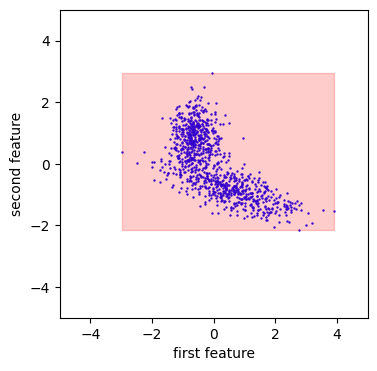

In [76]:
######################  box uncertainty set #########################
area = 0
for i, X in enumerate([X_scaled]):
       
#     scaler = preprocessing.StandardScaler().fit(X)
    
#     X_scaled = scaler.transform(X)
    start_box = time.time()
    X_min = np.min(X_scaled,axis = 0).reshape(-1,1)
    X_max = np.max(X_scaled,axis = 0).reshape(-1,1)
    
    X1_min_max = [X_min[0,:],X_max[0,:]]
    X2_min_max = [X_min[1,:],X_max[1,:]]
    
    end_box = time.time()
    points = []
    for pca_a in X1_min_max:
        for pca_b in X2_min_max:
            points.append([pca_a,pca_b])
    
    
    fig, axs = plt.subplots(figsize=(4,4))
    
    axs.scatter(X_scaled[:,0], X_scaled[:,1], 0.5, color = "b")
    
    shp = alphashape.alphashape(points, alpha = 0.)
    shp_pts = list(shp.exterior.coords)
    
    shp_x, shp_y = zip(*shp_pts)
    
    axs.fill(shp_x, shp_y, alpha = 0.2, color = "r")
    
    area += shapely.area(shp)

    for comp, max_norm in zip(pca.components_, pca_max):
        
        comp = comp*max_norm
        # axs.plot(
        #     [0, comp[0]],
        #     [0, comp[1]],
        #     linewidth = 1,
        #     color = f"C{i+1}"
        # )
        
        
axs.set(
aspect="equal",
#        title="2-dimensional dataset with principal components",
xlabel="first feature",
ylabel="second feature",xlim = [-5,5],ylim = [-5,5])

plt.savefig("box.png",bbox_inches = "tight")
print("the area of the uncertainty set is: ", area)
print("box uncertainty set computation time:", end_box - start_box)
check_coverage(X_scaled, shp)

the area of the uncertainty set is:  24.03903384850927
the computation time of PCA is:  0.001003265380859375
percentage of coverage is:  0.999


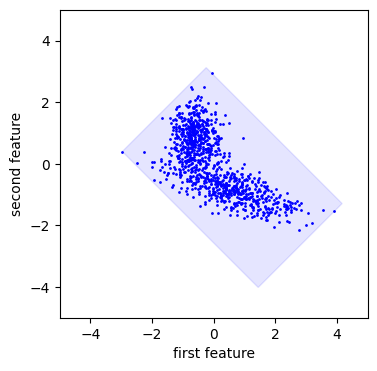

In [47]:
area = 0
for i, X in enumerate([X_scaled]):
       
#     scaler = preprocessing.StandardScaler().fit(X)
    
#     X_scaled = scaler.transform(X)
    start_pca = time.time()
    pca = PCA(n_components = 2).fit(X)
    
    
    X_pca = pca.fit_transform(X_scaled)
    
    pca_min = np.min(X_pca,axis = 0).reshape(-1,1)
    pca_max = np.max(X_pca,axis = 0).reshape(-1,1)
    
    X_min = pca.components_*pca_min
    X_max = pca.components_*pca_max

    end_pca = time.time()
    
    P1_min_max = [X_min[0,:],X_max[0,:]]
    P2_min_max = [X_min[1,:],X_max[1,:]]
    
    
    points = []
    for pca_a in P1_min_max:
        for pca_b in P2_min_max:
            points.append(pca_a+pca_b)
    
    
    fig, axs = plt.subplots(figsize=(4,4))
    
    axs.scatter(X_scaled[:,0], X_scaled[:,1], 1, color = "b")
    
    shp = alphashape.alphashape(points, alpha = 0.)
    shp_pts = list(shp.exterior.coords)
    
    shp_x, shp_y = zip(*shp_pts)
    
    axs.fill(shp_x, shp_y, alpha = 0.1, color = "b")
    
    area += shapely.area(shp)

    for comp, max_norm in zip(pca.components_, pca_max):
        
        comp = comp*max_norm
        # axs.plot(
        #     [0, comp[0]],
        #     [0, comp[1]],
        #     linewidth = 1,
        #     color = f"C{i+1}"
        # )
        
        
axs.set(
aspect="equal",
#        title="2-dimensional dataset with principal components",
xlabel="first feature",
ylabel="second feature",xlim = [-5,5],ylim = [-5,5])

plt.savefig("pca.pdf",bbox_inches = "tight")
print("the area of the uncertainty set is: ", area)
print("the computation time of PCA is: ", end_box-start_box)
check_coverage(X_scaled, shp)

In [120]:
points

[array([-0.21894613, -3.74776599]),
 array([-4.65031006,  0.68359794]),
 array([4.07727884, 0.54845897]),
 array([-0.35408509,  4.97982291])]

17.37782380300709
percentage of coverage is:  0.992


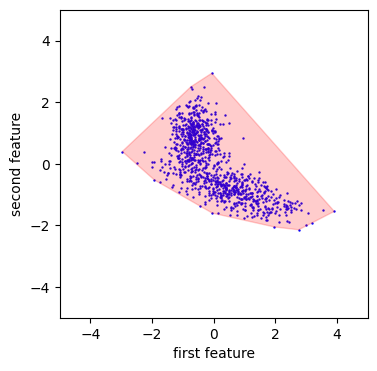

In [77]:

fig, axs = plt.subplots(figsize = (4,4))

axs.scatter(X_scaled[:,0], X_scaled[:,1],0.5,color="b")

shp = alphashape.alphashape(list(zip(X_scaled[:,0],X_scaled[:,1])), alpha = 0)
shp_pts = list(shp.exterior.coords)

shp_x, shp_y = zip(*shp_pts)

axs.fill(shp_x, shp_y, alpha = 0.2,color = "r")
axs.set(
aspect="equal",
#        title="2-dimensional dataset with principal components",
xlabel="first feature",
ylabel="second feature",xlim = [-5,5],ylim = [-5,5])


print(shapely.area(shp))
plt.savefig("cvh.png",bbox_inches = "tight")
check_coverage(X_scaled, shp)

(5000,)
[-2.107113921905631, 3.288419113957491]
(5000,)
[-1.3521785719269697, 1.256905633993628]
the area of the uncertainty set is:  14.077400026393288
computation time of kde is:  -0.19956088066101074


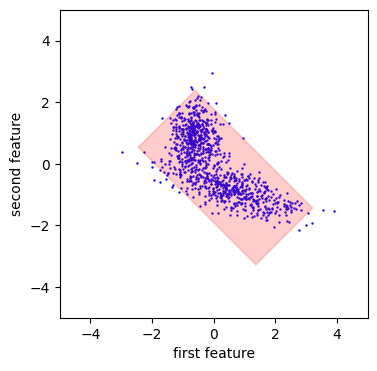

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

start_kde = time.time()
X_mean = X_scaled.mean(axis = 0)
X = X_scaled - X_mean
pca = PCA(n_components = 2).fit(X)
X_pca = pca.fit_transform(X)

area = 0
pca_min_max = []
for i in range(X_pca.shape[1]):
    data = X_pca[:,i]
# Perform kernel density estimation
    kde = gaussian_kde(data)

    data_min = np.min(data)
    data_max = np.max(data)
    # Define a range of values for which to calculate PDF and CDF
    x_values = np.linspace(data_min, data_max, 5000)
    
    # Calculate PDF using the KDE object
    pdf_values = kde.pdf(x_values)
    
    # Calculate CDF by taking cumulative sum of PDF values
    cdf_values = np.cumsum(pdf_values)*((data_max - data_min)/len(x_values))
    print(cdf_values.shape)
    min_max = [np.min(x_values[cdf_values>= 0.0125]), np.min(x_values[cdf_values >=0.9875])]
    print(min_max)
    pca_min_max.append(min_max)

end_kde = time.time()
########################################################


ext_points = [] ### extreme points 
for pca_1 in pca_min_max[0]:
    for pca_2 in pca_min_max[1]:
        ext_points.append([pca_1,pca_2])
        
points = []        
for point in ext_points:
    points.append(X_mean + pca.components_.T@np.array(point))

fig, axs = plt.subplots(figsize=(4,4))
    
axs.scatter(X_scaled[:,0], X_scaled[:,1], 0.5, color = "b")
    
shp = alphashape.alphashape(points, alpha = 0.)
shp_pts = list(shp.exterior.coords)

shp_x, shp_y = zip(*shp_pts)

axs.fill(shp_x, shp_y, alpha = 0.2, color = "r")

area += shapely.area(shp)

axs.set(
aspect="equal",
#        title="2-dimensional dataset with principal components",
xlabel="first feature",
ylabel="second feature",xlim = [-5,5],ylim = [-5,5])

plt.savefig("kde.pdf",bbox_inches = "tight")
print("the area of the uncertainty set is: ", area)
print("computation time of kde is: ", start_kde - end_kde)
#print("the computation time of PCA is: ", end_box-start_box)

In [ ]:
#list(zip(X_clean[:,0],X_clean[:,1]))
kmeans.labels_.shape

(5000,)
[-1.4813588339179717, 1.533008550137127]
(5000,)
[-0.9968889380246913, 1.1243510866937905]
(5000,)
[-1.466009303442063, 2.2609205657114186]
(5000,)
[-0.7531772231935416, 0.777864789770534]
the area of the uncertainty set is:  11.482569321605018
computation time of kde is:  0.38124871253967285
percentage of coverage is:  0.965


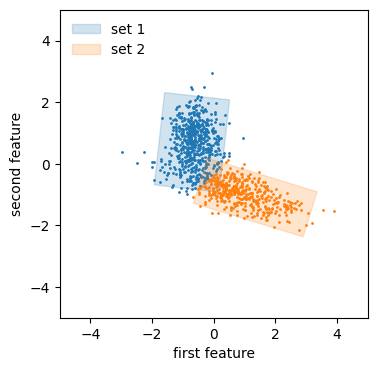

In [88]:
###################################################
###### Kmeans + PCA + KDE
###################################################
from sklearn.cluster import KMeans

n_clusters = 2
kmeans = KMeans(n_clusters = n_clusters, n_init = 200).fit(X_scaled)

X_kmeans_list = []
for i in range(n_clusters):
    X_kmeans_list.append(X_scaled[kmeans.labels_ == i,:])


start_kde = time.time()
#X_mean = X_scaled.mean(axis = 0)

fig, axs = plt.subplots(figsize=(4,4))
area = 0
shp_list_pkde = []

for k, X_kmeans in enumerate(X_kmeans_list):
    X_mean = X_kmeans.mean(axis = 0)
    X = X_kmeans - X_mean
    pca = PCA(n_components = 2).fit(X)
    X_pca = pca.fit_transform(X)
    
    # area = 0
    pca_min_max = []
    for i in range(X_pca.shape[1]):
        data = X_pca[:,i]
    # Perform kernel density estimation
        kde = gaussian_kde(data)
    
        data_min = np.min(data) - 0.2
        data_max = np.max(data) + 0.2
        # Define a range of values for which to calculate PDF and CDF
        x_values = np.linspace(data_min, data_max, 5000)
        
        # Calculate PDF using the KDE object
        pdf_values = kde.pdf(x_values)
        
        # Calculate CDF by taking cumulative sum of PDF values
        cdf_values = np.cumsum(pdf_values)*((data_max - data_min)/len(x_values))
        print(cdf_values.shape)
        min_max = [np.min(x_values[cdf_values>= 0.0125]), np.min(x_values[cdf_values >=0.9875])]
        print(min_max)
        pca_min_max.append(min_max)
    
    end_kde = time.time()
    ########################################################
    
    
    ext_points = [] ### extreme points 
    for pca_1 in pca_min_max[0]:
        for pca_2 in pca_min_max[1]:
            ext_points.append([pca_1,pca_2])
            
    points = []        
    for point in ext_points:
        points.append(X_mean + pca.components_.T@np.array(point))
        
    axs.scatter(X_kmeans[:,0], X_kmeans[:,1], 1, color =  f"C{k}")
        
    shp = alphashape.alphashape(points, alpha = 0.)
    shp_pts = list(shp.exterior.coords)
    
    shp_x, shp_y = zip(*shp_pts)
    
    axs.fill(shp_x, shp_y, alpha = 0.2, color =  f"C{k}", label = "set {k}".format(k = k+1))

    shp_list_pkde.append(shp)
    
#    area += shapely.area(shp)

axs.set(
aspect="equal",
#        title="2-dimensional dataset with principal components",
xlabel="first feature",
ylabel="second feature",xlim = [-5,5],ylim = [-5,5])
axs.legend(loc = 2, frameon = False)
union_polygon = shp_list_pkde[0]
for shape in shp_list_pkde[1:]:
    union_polygon = union_polygon.union(shape)

union_polygon.area

plt.savefig("kmeans_pkde.png",bbox_inches = "tight")
print("the area of the uncertainty set is: ", union_polygon.area)
print("computation time of kde is: ", end_kde - start_kde )
check_coverage(X_scaled, union_polygon)
#print("the computation time of PCA is: ", end_box-start_box)

In [ ]:



pca = PCA(n_components=2).fit(X)

plt.scatter(X[:, 0], X[:, 1], alpha=0.3, label="samples")
for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
    comp = comp * var  # scale component by its variance explanation power
    print(comp)
    plt.plot(
        
        [0, comp[0]],
        [0, comp[1]],
        label=f"Component {i}",
        linewidth=5,
        color=f"C{i + 2}",
    )
    
#     plt.gca().set(
#     aspect="equal",
#     title="2-dimensional dataset with principal components",
#     xlabel="first feature",
#     ylabel="second feature",
# )

In [ ]:
db = cluster.DBSCAN(eps = 5, min_samples = 5, ).fit(X)

In [53]:
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("noise is {0} percent of the total numbers".format(n_noise_ / (len(X))) )

NameError: name 'db' is not defined

In [54]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=8,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=4,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

NameError: name 'labels' is not defined

In [ ]:
X_clean = X[labels != -1,:]



gmm = GaussianMixture(n_components = 3,covariance_type = "diag")
gmm.fit(X_clean)


In [ ]:
plt.scatter(X_clean[:,0],X_clean[:,1], c = gmm.fit_predict(X_clean), cmap = plt.cm.winter)

In [55]:
####### kernel-based support vector machine ##########
svm_start = time.time()

X_train = X_scaled
N = len(X_train)
C_mat = np.cov(X_train.T)#(X_train.T@X_train - np.sum(X_train, axis = 0).reshape(-1,1).T@np.sum(X_train, axis = 0).reshape(1,-1))/(N-1)


v, P = np.linalg.eig(C_mat)
Q = P@np.diag(v**(-0.5))@np.linalg.inv(P)

def Kernel(w,v): #### define kernel function
    L = 5000
    ### C is the covariance matrix
    return L - np.linalg.norm(Q@(w - v), ord = 1) 

Ker_mat = np.eye(N)
for i in range(N):
    for j in range(N):
        Ker_mat[i,j] = Kernel(X_train[i,:],X_train[j,:])
        
# def K_SVM(alpha, Ker_mat): #### 
#     sum( sum(alpha[i]*alpha[j]*Ker_mat[i,j] for j in range(N)) for i in range(N) ) - \
#     sum(alpha[i]*Ker_mat[i,i] for i in range(N))
    
# cons = {"type": "eq", "fun": lambda x: sum(x) - 1}


import gurobipy as gp
from gurobipy import GRB
nu = 0.05 # 1e-8


m = gp.Model("K_SVM")
alpha = m.addMVar(shape = N, vtype = GRB.CONTINUOUS, lb = 0.0, ub = 1/(N*nu))
m.addConstr(sum(alpha) == 1)

# Obj = gp.QuadExpr()
# Obj += (sum( sum(alpha[i]*alpha[j]*Ker_mat[i,j] for j in range(N)) for i in range(N) ) -
#     sum(alpha[i]*Ker_mat[i,i] for i in range(N)))

Obj_new = gp.QuadExpr()
Obj_new += alpha@(Ker_mat@alpha) - alpha@np.diag(Ker_mat)

m.setObjective(Obj_new, GRB.MINIMIZE)

#m.setObjective(Obj, GRB.MINIMIZE)

# m.Params.MIPGapAbs = 1e-3
m.optimize()
svm_end = time.time()

print("computation time of svm is: ", svm_end - svm_start)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-10
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) W-2223 CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 1000 columns and 1000 nonzeros
Model fingerprint: 0xb36ca595
Model has 500500 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+03, 5e+03]
  QObjective range [1e+04, 2e+04]
  Bounds range     [2e-02, 2e-02]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.12s
Presolved: 1 rows, 1000 columns, 1000 nonzeros
Presolved model has 500500 quadratic objective terms
Ordering time: 0.04s

Barrier statistics:
 Free vars  : 999
 AA' NZ     : 4.995e+05
 Factor NZ  : 5.005e+05 (roughly 5 MB of memory)
 Factor Ops : 3.338e+08 (less than 1 second per iteration)
 Threads    : 4

  

In [56]:
K_eig, K_c = np.linalg.eig(Ker_mat)
np.min(K_eig)

0.000602111222502269

In [57]:
# ksvm_accuracy = 1e-8
# SV_idx = (ksvm_accuracy < alpha.X)
# BSV_idx = (0 < alpha.X) & (alpha.X < 1/(N*nu))
# Out_idx = alpha.X >= (1/(N*nu) - ksvm_accuracy)
# Iner_idx = alpha.X <= ksvm_accuracy

ksvm_accuracy = 1e-8
SV_idx = (ksvm_accuracy < alpha.X)
BSV_idx = (0 + ksvm_accuracy < alpha.X) & (alpha.X < (1/(N*nu) - ksvm_accuracy) )
Out_idx = alpha.X >= (1/(N*nu) - ksvm_accuracy)
Iner_idx = alpha.X <= ksvm_accuracy

print("total portion of support vectors is: ", sum(SV_idx)/len(SV_idx))
print("total portion of boundary support vectors is: ", sum(BSV_idx)/len(SV_idx))
print("total portion of outliers is: ", sum(Out_idx)/len(Out_idx))
print("total portion of interiors is: ", sum(Iner_idx)/len(Iner_idx))


multi_alpha = alpha.x[SV_idx]
SV_data = X_scaled[SV_idx,:]
BSV_data = X_scaled[BSV_idx,:]
Out_data = X_scaled[Out_idx,:]
Iner_data = X_scaled[Iner_idx,:]

total portion of support vectors is:  0.055
total portion of boundary support vectors is:  0.007
total portion of outliers is:  0.048
total portion of interiors is:  0.945


In [79]:
sum(SV_idx)*2

110

In [59]:
################## uncertainty set construction ####################
feature1 = np.linspace(-6,6,200)
feature2 = np.linspace(-6,6,200)

w_list = [] ######### coordinates of data #########

# for fe1 in feature1:
#     for fe2 in feature2:
#         w_list.append(np.array([fe1,fe2]))
        
# theta = np.max([sum( multi_alpha[i]*np.linalg.norm(Q@(BSV_data[j] - SV_data[i])) for i in range(len(SV_data)) ) for j in range(len(BSV_data))])

# point_idx = np.zeros(len(w_list))

# for i in range(len(w_list)):
#     w = w_list[i]
#     if sum( multi_alpha[k]*np.linalg.norm(Q@(w - SV_data[k]), 1) for k in range(len(SV_data)) ) <= theta:
#         point_idx[i] = 1

#############################################################

theta = np.max([sum( multi_alpha[i]*np.linalg.norm(Q@(BSV_data[j] - SV_data[i]), ord = 1) for i in range(len(SV_data)) ) for j in range(len(BSV_data))])
#theta = np.quantile([sum( multi_alpha[i]*np.linalg.norm(Q@(BSV_data[j] - SV_data[i])) for i in range(len(SV_data)) ) for j in range(len(BSV_data))], 1)
##########################################################
x_in = 0
for t in range(len(X_scaled)):
    if sum( multi_alpha[k]*np.linalg.norm(Q@(X_scaled[t,:] - SV_data[k,:]), 1) for k in range(len(SV_data)) ) <= theta:
        x_in += 1
print("the percentage of outliers is: ", 1 - x_in/len(X_scaled))
###########################################################    


point_idx = np.zeros(len(feature1)*len(feature2))

for fe1 in feature1:
    for fe2 in feature2:
        w = np.array([fe1,fe2])
        w_list.append(w)
        
        if sum( multi_alpha[k]*np.linalg.norm(Q@(w - SV_data[k]), 1) for k in range(len(SV_data)) ) <= theta:
            point_idx[len(w_list)-1] = 1
#############################################################

points = np.array(w_list)[point_idx == 1]


the percentage of outliers is:  0.04800000000000004


the area of ksvc is  11.068811393651675
percentage of coverage is:  0.945


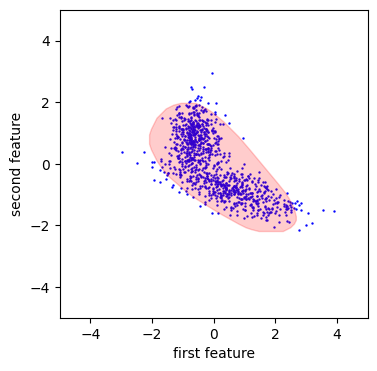

In [60]:
fig, axs = plt.subplots(figsize = (4,4))
axs.scatter(X_scaled[:,0], X_scaled[:,1], 0.5, color = "b")
#plt.scatter(SV_data[:,0], SV_data[:,1], 2, color = "red")
# axs.scatter(Iner_data[:,0], Iner_data[:,1], 1, color = "b")
# axs.scatter(Out_data[:,0], Out_data[:,1], 1, color = "k")
shp = alphashape.alphashape(points, alpha = 0)
shp_pts = list(shp.exterior.coords)

shp_x, shp_y = zip(*shp_pts)

axs.fill(shp_x, shp_y, alpha = 0.2, color = "r")
axs.set(
aspect="equal",
#        title="2-dimensional dataset with principal components",
xlabel="first feature",
ylabel="second feature",xlim = [-5,5],ylim = [-5,5])
plt.savefig("k_svm.png",bbox_inches = "tight")
print("the area of ksvc is ", shapely.area(shp))
check_coverage(X_scaled, shp)

In [ ]:
points

In [ ]:
# fig, axs = plt.subplots(figsize = (4,4))
# axs.scatter(X_train[:,0], X_train[:,1], 1, color = "b")
# #plt.scatter(SV_data[:,0], SV_data[:,1], 2, color = "red")
# axs.scatter(Iner_data[:,0], Iner_data[:,1], 1, color = "b")
# axs.scatter(Out_data[:,0], Out_data[:,1], 1, color = "k")
# shp = alphashape.alphashape(SV_data, alpha = 0)
# shp_pts = list(shp.exterior.coords)

# shp_x, shp_y = zip(*shp_pts)

# axs.fill(shp_x, shp_y, alpha = 0.1, color = "b")
# axs.set(
# aspect="equal",
# #        title="2-dimensional dataset with principal components",
# xlabel="first feature",
# ylabel="second feature",xlim = [-7,6],ylim = [-6,6])
plt.savefig("k_svm.pdf",bbox_inches = "tight")
print(shapely.area(shp))

In [ ]:
shp

In [ ]:
import xarray as xr
import cfgrib

In [ ]:
ds = xr.open_dataset(
"KNMI_weather_data/HA40_BEN_202311150900_00000_GB", engine = "cfgrib",filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround'})
ds

In [ ]:
ds = cfgrib.open_datasets(
"KNMI_weather_data/HA40_N25_202311151200_00000_GB")
ds

In [ ]:
df = ds.to_dataframe()
df

# plt.plot(df["unknown"].values)
# plt.plot(df["isobaricInhPa"].values)

In [ ]:
plt.plot(df["unknown"].values)

In [ ]:
data_set = xr.open_dataset(
"KNMI_weather_data/HA40_N55_202311150600_00100_GB",
engine = "cfgrib", filter_by_keys = {"typeOfLevel":"isobaricInhPa"})


In [ ]:
data_set.t

In [ ]:
def solar_predict(S_DNI, S_DHI, Ta):
    Am = 0
    theta_m = 28/360 * 2* np.pi
    As = 265/360*2*np.pi
    a_s = 30/360*2*np.pi
    lamb = -0.0038
    T_NOCT = 45
    Pr = 327
    
    Sm_DNI = S_DNI*(np.sin(theta_m) * np.cos(a_s) * np.cos(Am - As) + np.cos(theta_m) * np.sin(a_s))
    Sm_DHI = S_DHI*(1+ np.cos(theta_m))/2
    Sm = Sm_DHI + Sm_DNI 
    
    T_cell = Ta + Sm/800*(T_NOCT - 20)
    P_m = Pr*Sm/1000*(1 - lamb*(T_cell - 25))
    
    return P_m

pv_all = {"citg": np.array([]), "bk": np.array([]), "ewi": np.array([]), "gv": np.array([])}
for loc in loc_list:
    pv_all[loc] = solar_predict(0.5*solar_all[loc],0.5*solar_all[loc],temp_all[loc])


In [ ]:
pv_diff1 = pv_all["bk"] - pv_all["gv"]
pv_diff2 = pv_all["ewi"] - pv_all["gv"]
pv_diff3 = pv_all["citg"] - pv_all["gv"]

In [ ]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(projection = '3d')
ax1.scatter(temp_diff2,solar_diff2,pv_diff2)

fig2 = plt.figure()
ax2 = fig2.add_subplot(projection = '3d')
ax2.scatter(temp_diff3,solar_diff3,pv_diff3)

In [ ]:
fig, axs = plt.subplots(1,2)
axs[0].scatter(temp_diff2, solar_diff2, pv_diff2)

In [ ]:
out_air_temperature = file_obj.variables["out_air_temperature"]
out_air_temperature

In [ ]:
plt.plot(out_air_temperature[:])

In [ ]:
time = file_obj.variables["time"]
time

In [ ]:
import numpy.ma as ma
y = ma.array([1,np.nan,3], mask = [0,1,0])
np.mean(y)
y

In [ ]:
len(y.data)

In [ ]:
long = file_obj.variables["longitude"][:].data
lati = file_obj.variables["latitude"][:].data

plt.contourf(long, lati, out_air_temperature[:].data)

In [ ]:
np.ma.masked

In [ ]:
delta = 0.025

x = y = np.arange(-3.0, 3.01, delta)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
Z = (Z1 - Z2) * 2

nr, nc = Z.shape

# put NaNs in one corner:
Z[-nr // 6:, -nc // 6:] = np.nan
# contourf will convert these to masked


Z = np.ma.array(Z)
# mask another corner:
Z[:nr // 6, :nc // 6] = np.ma.masked

# mask a circle in the middle:
interior = np.sqrt(X**2 + Y**2) < 0.5
Z[interior] = np.ma.masked

In [ ]:
plt.contourf(X,Y,Z)

In [ ]:
x